In [5]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.colors import DEFAULT_PLOTLY_COLORS as default_colors
from plotly.subplots import make_subplots

from QSSBuilder import QSSBuilder

# Calculating many steady-states.
Here we loop through a whole bunch of states and calculate the output power, reeling factor, and other outputs for it. This is then saved as a csv file in the results folder.

In [6]:
# qss = QSSBuilder("MegAWES")  # When you want to start fresh.
qss = QSSBuilder.from_csv("MegAWES")  # When you want to continue from an existing csv.

Done loading MegAWES.csv


In [ ]:
# Combine all possible combinations of states, and calculate the output if it didn't
# exist in the DataFrame already. This might even take a while when there re no new
# combinations as it takes a while to check that.
qss.add_steady_states(
    {
        "vw_mps": np.unique(np.linspace(0, 30, 13)),
        "Lt_m": np.unique(np.linspace(500, 1500, 3, dtype=int)),
        "phi_deg": [0.0, 17.5],
        "beta_deg": [0.0, 30],
        "chi_deg": np.unique(np.linspace(0, 180, 5, dtype=int)),
        # TODO: Smarter way to find different Ftk_N that work than looping over all values.
        # Use dtype int for the merge into an existing DataFrame to be less error-prone.
        # Otherwise it sometimes couldn't match two floats with each other. Integer
        # precision is also more than enough here.
        # "Ftk_N": np.unique(np.logspace(1, 7, 103, dtype=int)),
        "Ftk_N": np.unique(np.arange(10, 1e7, 2500, dtype=int)),
    }
)
qss.save_df()

In [7]:
qss_massless = QSSBuilder.from_csv("MegAWES_massless")

Done loading MegAWES_massless.csv


In [ ]:
qss_massless.add_steady_states(
    {
        "vw_mps": np.unique(np.linspace(0, 30, 13)),
        "Lt_m": np.unique(np.linspace(500, 1500, 3, dtype=int)),
        "phi_deg": [0.0, 17.5],
        "beta_deg": [0.0, 30],
        "chi_deg": np.unique(np.linspace(0, 180, 5, dtype=int)),
        "Ftk_N": np.unique(np.arange(10, 1e7, 2500, dtype=int)),
    }
)
qss_massless.save_df()

# Processing
We want to find the optimal state to operate in. So by sorting the values by generated power, we can find the combination of beta, phi, chi, Lt, and vw that yields the highest power. The optimal tether force (at the kite and ground), reeling factor, reeling speed, and power will be saved as `_star` variables in the DataFrame.
- [ ] Make sure to already have run the `quasi_steady_state_massless_analysis.ipynb` to compare these results to.

In [8]:
temp = qss.df.sort_values("P_W", ascending=False)
qss_star = temp.drop_duplicates(
    ["beta_deg", "phi_deg", "chi_deg", "Lt_m", "vw_mps"],
    keep="first",
    ignore_index=True,
).copy()
star_dict = {
    "Ftk_N": "Ftk_N_star",
    "f": "f_star",
    "Ftg_N": "Ftg_N_star",
    "P_W": "P_W_star",
    "vr_mps": "vr_mps_star",
}
qss_star = qss_star.rename(columns=star_dict)

temp = qss_massless.df.sort_values("P_W", ascending=False)
qss_massless_star = temp.drop_duplicates(
    ["beta_deg", "phi_deg", "chi_deg", "Lt_m", "vw_mps"],
    keep="first",
    ignore_index=True,
).copy()
qss_massless_star = qss_massless_star.rename(columns=star_dict)

qss_massless_analytical = pd.read_csv("../results/MegAWES_massless_analytical.csv")
qss_massless_analytical_star = pd.read_csv(
    "../results/MegAWES_massless_analytical_star.csv"
)

In [9]:
qss_star["param_name"] = "MegAWES"
qss_massless_star["param_name"] = "MegAWES_massless"
qss_massless_analytical_star["param_name"] = "MegAWES_massless_analytical"
df_massless = pd.concat(
    [qss_massless_star, qss_massless_analytical_star], ignore_index=True
)
df = pd.concat(
    [qss_star, qss_massless_star, qss_massless_analytical_star], ignore_index=True
)

# Compare analytical and qsm massless

In [10]:
import my_plotly_themes

On this screen 15.75 cm is 675 pixels wide.


In [12]:
fig = px.line(
    df_massless,
    x="vw_mps",
    y="P_W_star",
    color="param_name",
    symbol="Lt_m",
    facet_col="beta_deg",
    facet_row="phi_deg",
)
fig.write_image("../results/qsm_massless_vs_analytical.png")
fig.show()

# Plotting

In [151]:
# Linewidth in latex is 15.75 cm, which is 15.75/2.54 inch. I make it a bit larger which
# makes the text a bit smaller, but the figure a little bigger.
FULLSIZE = (15.75 / 2.54 + 3, 4)
PARTSIZE = (0.7 * (15.75 / 2.54 + 3), 4)

# TODO: Can do more customisation for how the plots look like if needed.
# From awe_workshop.
# # Configure the default plotting settings
# size=13
# params = {'legend.fontsize': 'large',
#           'figure.figsize': (8,5),
#           'axes.labelsize': size,
#           'axes.titlesize': size,
#           'xtick.labelsize': size*0.85,
#           'ytick.labelsize': size*0.85,
#           'axes.titlepad': 25}
# plt.rcParams.update(params)

# Seaborn sets the x and y axis labels to the column names, but we want them to be a bit
# more human-readable.
var_to_label = {
    'vw_mps': 'wind speed [m/s]',
    'Lt_m': 'tether length [m]',
    'phi_deg': 'azimuth [deg]',
    'beta_deg': 'elevation [deg]',
    'chi_deg': 'course angle [deg]',
    'Ftk_N_star': 'tether force kite [N]',
    'f_star': 'reeling factor [-]',
    'Ftg_N_star': 'tether force [N]',
    'Ftg_N': 'tether force [N]',
    'P_W_star': 'power [W]',
    'P_W': 'power [W]',
    'E_eff': 'effective lift-to-drag ratio [-]',
    'vr_mps_star': 'reel-out speed [m/s]',
    'vr_mps': 'reel-out speed [m/s]',
}
def set_labels(axs):
    # If axs is an iterable, loop over all the individual axis.
    if hasattr(axs, '__iter__'):
        for ax in axs:
            set_labels(ax)

    else:
        axs.set_xlabel(var_to_label[axs.get_xlabel()])
        axs.set_ylabel(var_to_label[axs.get_ylabel()])

        # Also the legend.
        leg = axs.get_legend()
        if leg.get_visible():
            try:
                leg.set_title(var_to_label[leg.get_title().get_text()])

            # When hue and style are set, Seaborn doesn't set the title but just puts
            # multiple texts in the legend. With some digging into the source code we
            # can still fit it.
            except Exception:
                for T in leg.texts:
                    if T._text in var_to_label.keys():
                        T._text = var_to_label[T._text]

### Loyd

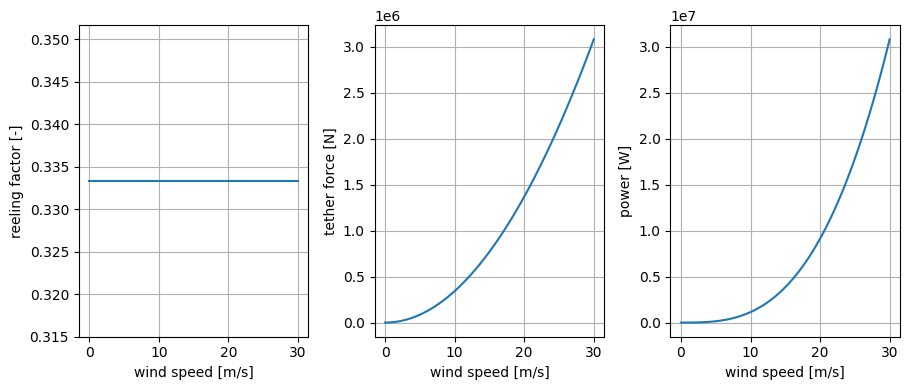

In [21]:
# fFP (reeling factor, tether force, power) graph for massless system for beta and phi
# equal to zero and a certain tether length.
temp = qss_massless_analytical_star[
    (qss_massless_analytical_star["beta_deg"] == 0)
    & (qss_massless_analytical_star["phi_deg"] == 0)
    & (qss_massless_analytical_star["Lt_m"] == 1000)
]

fig, axs = plt.subplots(1, 3, figsize=FULLSIZE)

for i, y in enumerate(["f_star", "Ftg_N_star", "P_W_star"]):
    sns.lineplot(temp, x="vw_mps", y=y, ax=axs[i])
    axs[i].grid()

set_labels(axs)
plt.tight_layout()
plt.savefig("../results/fFP_Loyd.png")


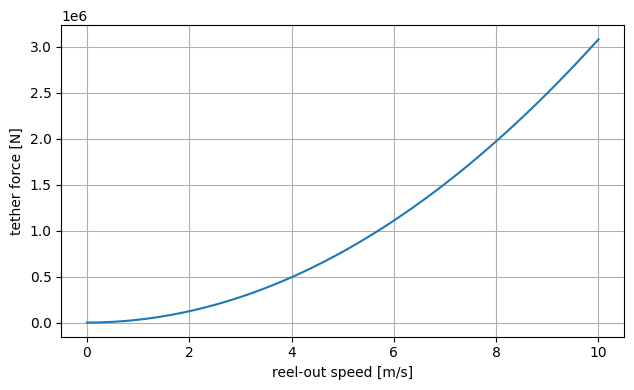

In [24]:
# vr-Ft Loyd
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
sns.lineplot(temp, x="vr_mps_star", y="Ftg_N_star", ax=ax)
ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_Loyd.png")


### Beta and phi

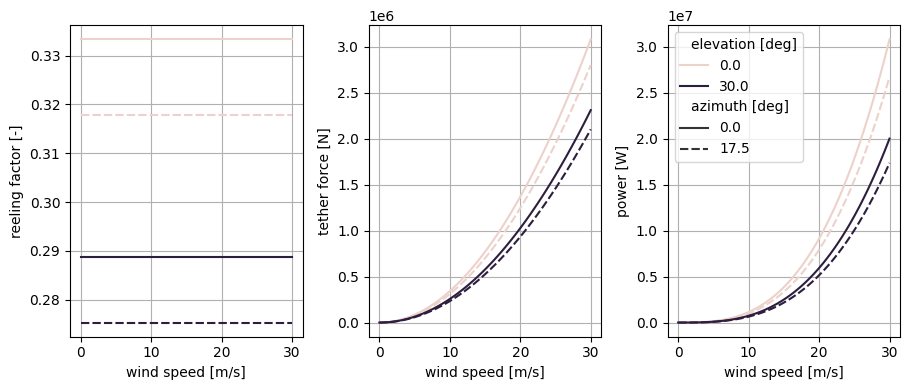

In [96]:
# fFP graph.
temp = qss_massless_analytical_star[(qss_massless_analytical_star["Lt_m"] == 1000)]

fig, axs = plt.subplots(1, 3, figsize=FULLSIZE)

for i, y in enumerate(["f_star", "Ftg_N_star", "P_W_star"]):
    sns.lineplot(temp, x="vw_mps", y=y, hue="beta_deg", style="phi_deg", ax=axs[i])
    axs[i].grid()
    if i != 2:
        axs[i].get_legend().set_visible(False)

set_labels(axs)
plt.tight_layout()
plt.savefig("../results/fFP_betaphi.png")

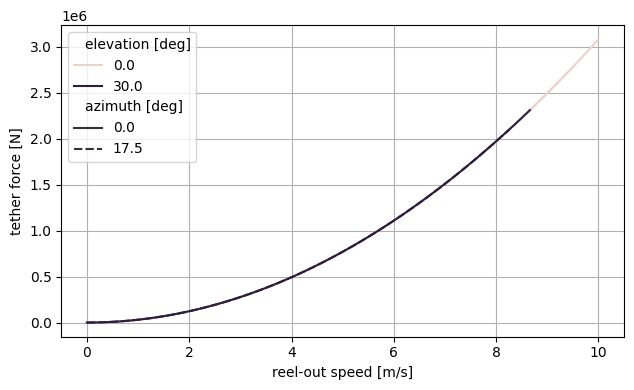

In [97]:
# vr-Ft
# This is a very interesting figure. It plots the ideal vr-Ft graph. If the winch
# ensures that the kite stays on this optimal vr-Ft line, it will operate at optimal
# (instantaneous) power output. As you can see, the lines for different elevation and
# azimuth are on top of each other. So one strategy can be used (when ignoring the
# effect of tether length and mass).
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
sns.lineplot(
    temp, x="vr_mps_star", y="Ftg_N_star", hue="beta_deg", style="phi_deg", ax=ax
)
ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_betaphi.png")

## Tether length

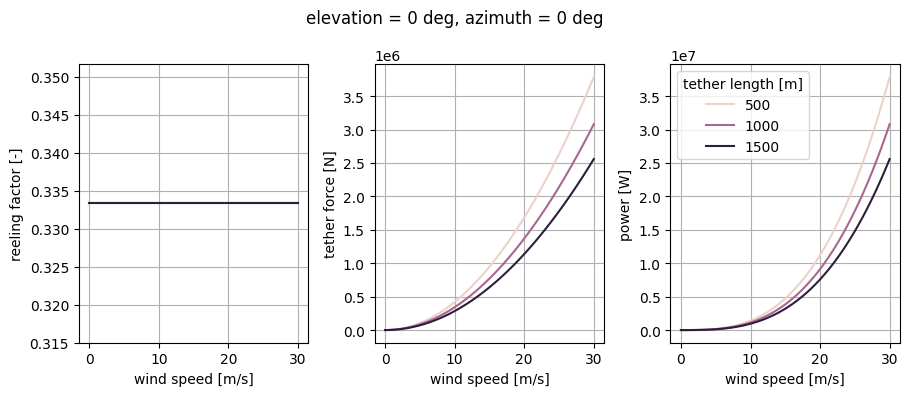

In [98]:
# fFP graph
beta_deg_bar = 0
phi_deg_bar = 0
temp = qss_massless_analytical_star[
    (qss_massless_analytical_star["beta_deg"] == beta_deg_bar)
    & (qss_massless_analytical_star["phi_deg"] == phi_deg_bar)
]

fig, axs = plt.subplots(1, 3, figsize=FULLSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg")

for i, y in enumerate(["f_star", "Ftg_N_star", "P_W_star"]):
    sns.lineplot(temp, x="vw_mps", y=y, hue="Lt_m", ax=axs[i])
    axs[i].grid()
    if i != 2:
        axs[i].get_legend().set_visible(False)

set_labels(axs)
plt.tight_layout()
plt.savefig("../results/fFP_Lt.png")


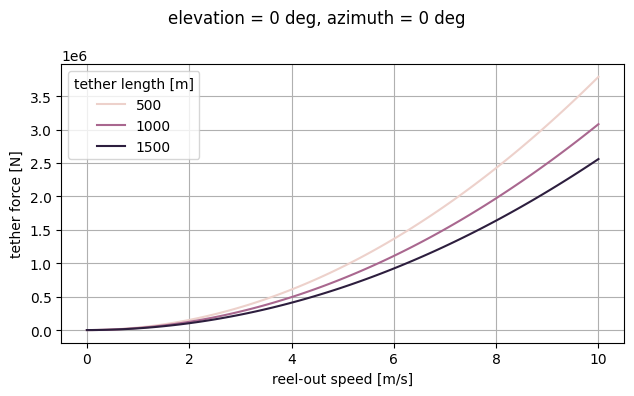

In [99]:
# vr-Ft
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg")

sns.lineplot(temp, x="vr_mps_star", y="Ftg_N_star", hue="Lt_m", ax=ax)

ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_Lt.png")

### Add mass, variable chi.

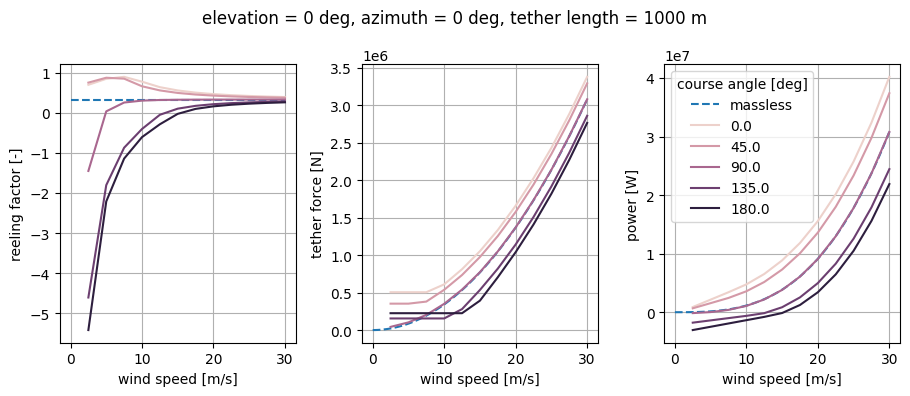

In [100]:
# fFP graph
beta_deg_bar = 0
phi_deg_bar = 0
# chi_deg_bar = 90
Lt_m_bar = 1000
temp = qss_star[
    (qss_star["Lt_m"] == Lt_m_bar)
    & (qss_star["beta_deg"] == beta_deg_bar)
    & (qss_star["phi_deg"] == phi_deg_bar)
    # & (qss_star['chi_deg'] == chi_deg_bar)
]
temp2 = qss_massless_analytical_star[
    (qss_massless_analytical_star["Lt_m"] == Lt_m_bar)
    & (qss_massless_analytical_star["beta_deg"] == beta_deg_bar)
    & (qss_massless_analytical_star["phi_deg"] == phi_deg_bar)
]

fig, axs = plt.subplots(1, 3, figsize=FULLSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, tether length = {Lt_m_bar} m")

for i, y in enumerate(["f_star", "Ftg_N_star", "P_W_star"]):
    sns.lineplot(temp2, x="vw_mps", y=y, ax=axs[i], label="massless")
    axs[i].lines[0].set_linestyle("--")
    sns.lineplot(temp, x="vw_mps", y=y, hue="chi_deg", ax=axs[i])
    axs[i].grid()
    if i != 2:
        axs[i].get_legend().set_visible(False)

set_labels(axs)
plt.tight_layout()
plt.savefig("../results/fFP_mass.png")


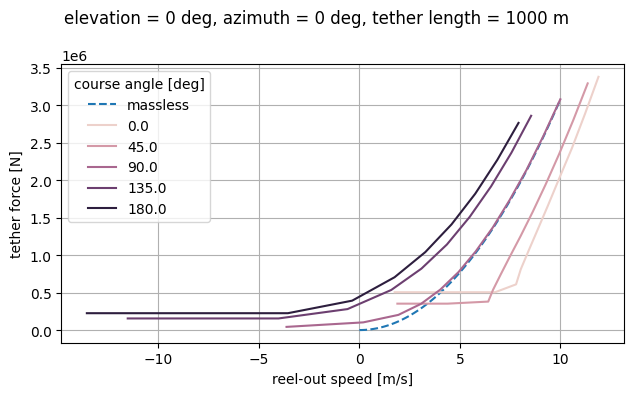

In [102]:
# vr-Ft
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, tether length = {Lt_m_bar} m")

sns.lineplot(temp2, x="vr_mps_star", y="Ftg_N_star", ax=ax, label="massless")
ax.lines[0].set_linestyle("--")
sns.lineplot(temp, x="vr_mps_star", y="Ftg_N_star", hue="chi_deg", ax=ax)

ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_mass.png")


### With mass, chi=90 but variable beta and phi again.
Massless underestimates the effect of beta and phi (right?)

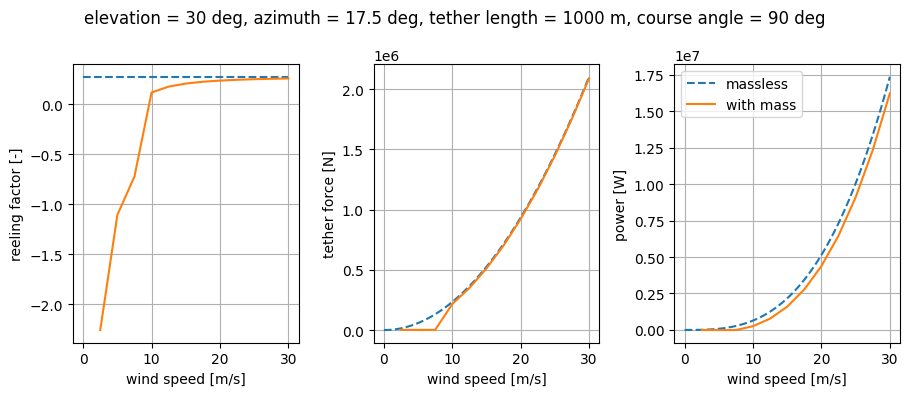

In [106]:
# fFP graph
beta_deg_bar = 30
phi_deg_bar = 17.5
chi_deg_bar = 90
Lt_m_bar = 1000
temp = qss_star[
    (qss_star["Lt_m"] == Lt_m_bar)
    & (qss_star["beta_deg"] == beta_deg_bar)
    & (qss_star["phi_deg"] == phi_deg_bar)
    & (qss_star["chi_deg"] == chi_deg_bar)
]
temp2 = qss_massless_analytical_star[
    (qss_massless_analytical_star["Lt_m"] == Lt_m_bar)
    & (qss_massless_analytical_star["beta_deg"] == beta_deg_bar)
    & (qss_massless_analytical_star["phi_deg"] == phi_deg_bar)
]

fig, axs = plt.subplots(1, 3, figsize=FULLSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, tether length = {Lt_m_bar} m, course angle = {chi_deg_bar} deg")

for i, y in enumerate(["f_star", "Ftg_N_star", "P_W_star"]):
    sns.lineplot(temp2, x="vw_mps", y=y, ax=axs[i], label="massless")
    axs[i].lines[0].set_linestyle("--")
    sns.lineplot(temp, x="vw_mps", y=y, ax=axs[i], label='with mass')
    axs[i].grid()
    if i != 2:
        axs[i].get_legend().set_visible(False)

set_labels(axs)
plt.tight_layout()
plt.savefig("../results/fFP_mass_betaphi.png")


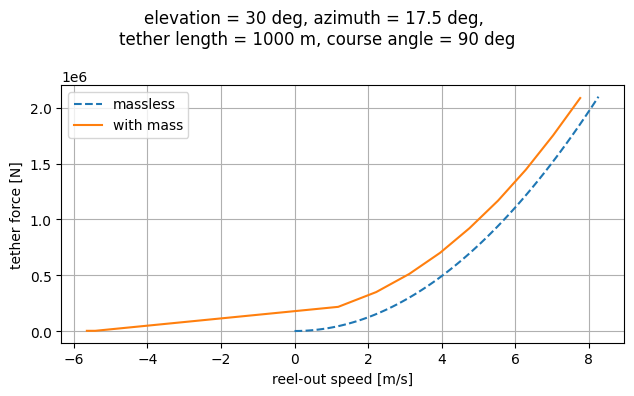

In [108]:
# vr-Ft
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, \ntether length = {Lt_m_bar} m, course angle = {chi_deg_bar} deg")

sns.lineplot(temp2, x="vr_mps_star", y="Ftg_N_star", ax=ax, label="massless")
ax.lines[0].set_linestyle("--")
sns.lineplot(temp, x="vr_mps_star", y="Ftg_N_star", ax=ax, label="with mass")

ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_mass_betaphi.png")


### Making the average operating condition
See my MSc report

In [113]:
def least_squares(X, y):
    return np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(), X)), X.transpose()), y)

In [114]:
# Fitting to the curve between 0.25e6 and 1e6.
Fmin = 0.25e6
Fmax = 1.0e6
fit_index = temp["Ftg_N_star"][
    (temp["Ftg_N_star"] > Fmin)
    & (temp["Ftg_N_star"] < Fmax)
    & (~temp["Ftg_N_star"].isna())
].index

vr = temp.loc[fit_index, "vr_mps_star"].values
vr2 = vr**2
ones = np.ones_like(vr)
X = np.asarray([ones, vr, vr2]).transpose()

y = temp.loc[fit_index, "Ftg_N_star"].values
theta_hat = least_squares(X, y)
theta_hat


array([146429.46730504,  28806.3128389 ,  28242.9409458 ])

In [115]:
def abc(a, b, c):
    return (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)


In [116]:
# Need to find the vr for which we reach Flim.
vr_power_lim = abc(theta_hat[2], theta_hat[1], theta_hat[0] - Fmax)
print(vr_power_lim, Fmax, vr_power_lim * Fmax / 1e6)


5.011123242630708 1000000.0 5.011123242630708


In [119]:
def my_winch_strategy(vr):
    F_star = theta_hat[0] + theta_hat[1] * vr + theta_hat[2] * vr**2

    F_star[vr < 0] = Fmin
    F_star = np.maximum(F_star, Fmin)
    # F_star = np.clip(F_star, Fmin, Fmax)
    return F_star


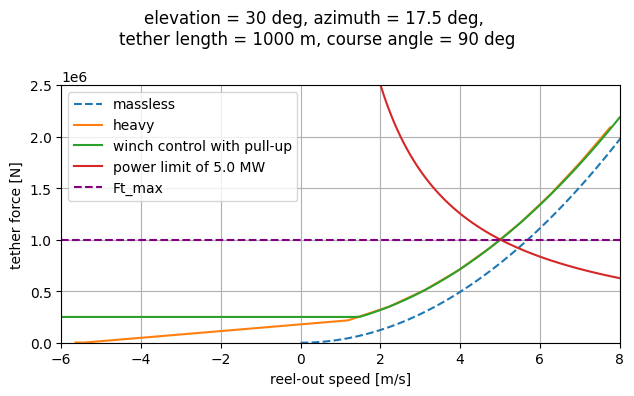

In [122]:
# vr-Ft
beta_deg_bar = 30
phi_deg_bar = 17.5
chi_deg_bar = 90
Lt_m_bar = 1000
temp = qss_star[
    (qss_star["Lt_m"] == Lt_m_bar)
    & (qss_star["beta_deg"] == beta_deg_bar)
    & (qss_star["phi_deg"] == phi_deg_bar)
    & (qss_star["chi_deg"] == chi_deg_bar)
]
temp2 = qss_massless_analytical_star[
    (qss_massless_analytical_star["Lt_m"] == Lt_m_bar)
    & (qss_massless_analytical_star["beta_deg"] == beta_deg_bar)
    & (qss_massless_analytical_star["phi_deg"] == phi_deg_bar)
]

fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, \ntether length = {Lt_m_bar} m, course angle = {chi_deg_bar} deg")

sns.lineplot(temp2, x="vr_mps_star", y="Ftg_N_star", ax=ax, label="massless")
ax.lines[0].set_linestyle("--")
sns.lineplot(temp, x="vr_mps_star", y="Ftg_N_star", ax=ax, label="heavy")
vr = np.linspace(-6, 8, 100)
sns.lineplot(x=vr, y=my_winch_strategy(vr), label="winch control with pull-up")

plt.ylim([0, 2.5e6])
plt.xlim([-6, 8])


ax.grid()
plt.tight_layout()
plt.savefig("../results/vrFt_mass_betaphi_fit.png")


vr_pos = np.linspace(0.1, 8, 100)
sns.lineplot(
    x=vr_pos,
    y=Fmax * vr_power_lim / vr_pos,
    label=f"power limit of {Fmax*vr_power_lim/1e6:.2} MW",
)
plt.hlines(1e6, -6, 8, color="purple", linestyles="--", label="Ft_max")
plt.legend()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_mass_betaphi_fit_power.png")


# Linear model around 0.25e6 tether force.

C:\Users\jesse\AppData\Local\Temp\ipykernel_19440\2080081436.py:49: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



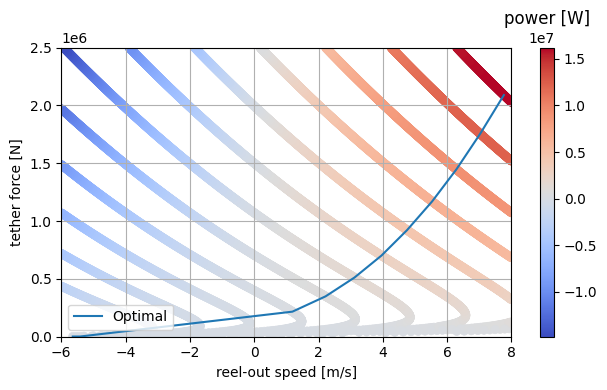

In [137]:
# Doing the same with seaborn is really difficult.
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)

df_optimal = qss_star[
    (qss_star["Lt_m"] == Lt_m_bar)
    & (qss_star["beta_deg"] == beta_deg_bar)
    & (qss_star["phi_deg"] == phi_deg_bar)
    & (qss_star["chi_deg"] == chi_deg_bar)
]

sns.lineplot(
    df_optimal,
    x="vr_mps_star",
    y="Ftg_N_star",
)
ax.legend(["Optimal"])

beta_deg_bar = 30
phi_deg_bar = 17.5
chi_deg_bar = 90
Lt_m_bar = 1000
qss_bar = qss.df[
    (qss.df["Lt_m"] == Lt_m_bar)
    & (qss.df["beta_deg"] == beta_deg_bar)
    & (qss.df["phi_deg"] == phi_deg_bar)
    & (qss.df["chi_deg"] == chi_deg_bar)
]

temp = qss_bar[
    (qss_bar["vr_mps"] > -6)
    & (qss_bar["vr_mps"] < 8)
    & (qss_bar["Ftg_N"] > 0)
    & (qss_bar["Ftg_N"] < 2.5e6)
]

cmap = plt.cm.get_cmap("coolwarm")
normalize = plt.Normalize(vmin=temp["P_W"].min(), vmax=temp["P_W"].max())

sns.scatterplot(
    temp,
    x="vr_mps",
    y="Ftg_N",
    hue="P_W",
    palette=cmap,
    ax=ax,
    # marker=',',
    edgecolor=None,
    legend=False,
)

plt.ylim([0, 2.5e6])
plt.xlim([-6, 8])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_title(var_to_label["P_W"])

ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_SI.png")


In [138]:
# Making the same graph in plotly is very easy.
px.scatter(temp, x="vr_mps", y="Ftg_N", color="P_W")

In [147]:
# Least-squares fit around 0.25e6N tether force.
temp = qss_bar[
    (qss_bar["vr_mps"] > -6)
    & (qss_bar["vr_mps"] < 8)
    & (qss_bar["Ftg_N"] > 0.20e6)
    & (qss_bar["Ftg_N"] < 0.30e6)
    # & (temp_nona['P_W'] > 0)
]

temp_nona = temp.dropna()

# Building the X matrix. (input data)
vr = temp_nona["vr_mps"].values
vr2 = vr**2
vw = temp_nona["vw_mps"].values
vw2 = vw**2
ones = np.ones_like(vr)
X = np.asarray([ones, vr, vw]).transpose()
# X = np.asarray([ones, vr, vw, vr**2, vw**2]).transpose()

# Outputs.
y = temp_nona["Ftg_N"].values

# Least-squares.
theta_hat = least_squares(X, y)
theta_hat


array([-696199.25993199, -150842.55048747,  109489.2433413 ])

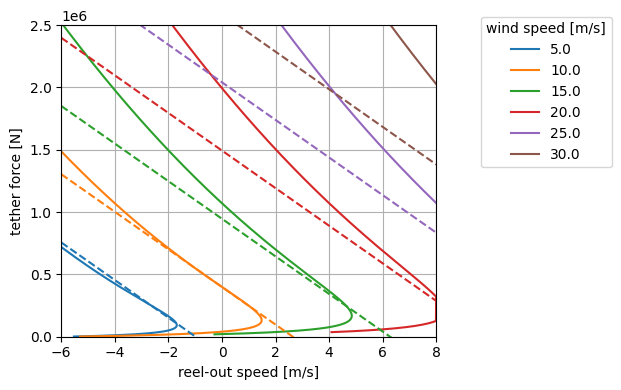

In [159]:
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)

beta_deg_bar = 30
phi_deg_bar = 17.5
chi_deg_bar = 90
Lt_m_bar = 1000
temp = qss_bar[
    (qss_bar["vr_mps"] > -6)
    & (qss_bar["vr_mps"] < 8)
    & (qss_bar["Ftg_N"] > 0)
    & (qss_bar["Ftg_N"] < 2.5e6)
    & (qss_bar['vw_mps'] % 5 == 0)
]

for vw, df in temp.groupby("vw_mps"):
    df = df.sort_values(by="Ftg_N")
    plt.plot(df["vr_mps"], df["Ftg_N"], label=vw)

ax.legend(bbox_to_anchor=(1.1, 1.05), title="vw_mps")

plt.gca().set_prop_cycle(None)
for vw in temp["vw_mps"].unique():
    vr = np.linspace(-6, 8, 100)
    Ft_hat = (
        theta_hat[0]
        + theta_hat[1] * vr
        + theta_hat[2] * vw
        # + theta_hat[3] * vr**2
        # + theta_hat[4] * vw**2
    )
    plt.plot(vr, Ft_hat, "--")

plt.ylim([0, 2.5e6])
plt.xlim([-6, 8])

plt.xlabel("vr_mps")
plt.ylabel("Ftg_N")

ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_SI_fit.png")
